In [277]:
%matplotlib inline

import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import random

import contextlib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras import metrics

# Getting the dataset

We will use here the dataset provided by the authors we will create a helper function to extract the features that we want.

In [278]:
data = pd.read_json("diplomacy_data/diplomacy_data.json")
data.head(2)

,seasons,game,betrayal,idx,people
0,"[{'season': 1906.5, 'interaction': {'victim': ...",74,True,0,AT
1,"[{'season': 1911.5, 'interaction': {'victim': ...",165,False,1,EG


In [305]:
def last_support(entry):
    """
    This function returns the last season of friendship. The code is inspired by the provided code from
    the authors
    """
    last_support = None
    for season in entry[:-1]:
        if 'support' in season['interaction'].values():
            last_support = season['season']
    return last_support

def get_first_support(entry):
    """
    This function returns the first season of friendship. 
    """
    for season in entry[:-1]:
        if 'support' in season['interaction'].values():
            return season['season']

    return None

def treat_msg_season(df):
    """
    This function loops over the whole dataset and creates a dictionnary with the set of features for each season 
    with its associated boolean (betrayal or not )
    """
    data_victim = {'features':[], 'betrayed':[]} # data of the (potential) victim 
    data_betrayer = {'features':[], 'betrayed':[]} # data of the (potential) betrayer
    for i in range(len(df.seasons.values)):
        entry = df['seasons'][i] # pick each entry
        for j in range(len(entry)): # pick each season
            season = entry[j]
            tab_vi = []
            tab_be = []
            if season['season'] <= last_support(entry): # check if the season is below the last season of friendship
                tab_vi.append(season['messages']['victim'])
                tab_be.append(season['messages']['betrayer'])
                if len(tab_be) != 0 and len(tab_vi) != 0: # keep only cases where both players have sent messages
                    data_victim['features'].append(tab_vi)
                    data_victim['betrayed'].append(df.betrayal.values[i])
                    data_betrayer['features'].append(tab_be)   
                    data_betrayer['betrayed'].append(df.betrayal.values[i])
    return data_victim, data_betrayer

data_victim, data_betrayer = treat_msg_season(data)

In [317]:
def collect_all_unique_words(message):
    words = message['frequent_words']
    for _, value in message['lexicon_words'].items():
        words += value
    
    return list(set(words))


def collect_all_disc_words(message):
    words = []
    for _, value in message['lexicon_words'].items():
        words += value
    return words

    
def to_dict(message):
    sentiment_positive = message['sentiment']['positive']
    sentiment_neutral = message['sentiment']['neutral']
    sentiment_negative = message['sentiment']['negative']
    n_requests = message['n_requests']
    frequent_words = message['frequent_words']
    all_words = collect_all_unique_words(message)
    disc_words = collect_all_disc_words(message)
    n_disc_words = len(collect_all_disc_words(message))
    n_words = message['n_words']
    politeness = message['politeness']
    n_sentences = message['n_sentences']
    return {"sentiment_positive": sentiment_positive,
           "sentiment_neutral": sentiment_neutral,
           'sentiment_negative': sentiment_negative,
           'n_requests': n_requests,
           'frequent_words': frequent_words,
           'n_words': n_words,
           'politeness': politeness,
           'n_sentences': n_sentences,
            'n_disc_words': n_disc_words,
            'disc_words': disc_words,
           'all_words': all_words}


def preprocessing(df):
    result = []
    for row in df.iterrows():
        row = row[1]
        betrayal = row['betrayal']
        idx = row['idx']
        for season in row['seasons']:
            s = season['season']
                
            last_s = last_support(row['seasons'])+0.5 # the betrayal occurs one season after the last support
            first_support = get_first_support(row['seasons'])
            if s <= last_support(row['seasons']) and len(season['messages']['betrayer']) and len(season['messages']['victim']): # here we also have to consider the last season before betrayal
                interaction_victim = season['interaction']['victim']
                interaction_betrayer = season ['interaction']['betrayer']
                for m_vic in season['messages']['victim']:
                    data = to_dict(m_vic)
                    data['role'] = 'victim'
                    data['season'] = s
                    data['betrayal'] = betrayal
                    data['season_betrayal'] = last_s
                    data['season_before_betrayal'] = (last_s-s)/0.5
                    data['idx'] = idx
                    data['friendship_length'] = (last_s-first_support) if first_support else 0
                    result.append(data)
                for m_bet in season['messages']['betrayer']:
                    data = to_dict(m_bet)
                    data['role'] = 'betrayer'
                    data['season'] = s
                    data['betrayal'] = betrayal
                    data['season_betrayal'] = last_s
                    data['season_before_betrayal'] = (last_s-s)/0.5
                    data['friendship_length'] = (last_s-first_support) if first_support else 0
                    data['idx'] = idx
                    result.append(data)
                            
    return pd.DataFrame(result).set_index(['idx', 'season'])

In [318]:
df = preprocessing(data)
df.head()

sentiment_positive  sentiment_neutral  sentiment_negative  \
idx season                                                              
0   1906.5                   0                  0                   2   
    1906.5                   1                  1                   4   
    1906.5                   1                  2                   1   
    1906.5                   4                  2                  13   
    1906.5                   1                  3                   5   

            n_requests                                     frequent_words  \
idx season                                                                  
0   1906.5           1  [just, bot, ,, ., take, unit, war, retreat, di...   
    1906.5           2  [armies, north, the, armies, on, ., your, with...   
    1906.5           2  [?, going, for, ser, balance, a, to, of, give,...   
    1906.5           8  [only, he, alb, ., forced, italy's, is, be, .,...   
    1906.5           7  [more, let, keep, we, side, we, don't, to, ., ...   

            n_words  politeness  n_sentences  n_disc_words  \
idx season                                                   
0   1906.5       35    0.367200            2             7   
    1906.5       77    0.932326            6            16   
    1906.5       55    0.983373            4            14   
    1906.5      313    0.957072           19            71   
    1906.5      146    0.832023            9            38   

                                                   disc_words  \
idx season                                                      
0   1906.5  [just, war, prefer, really, light, retreat, in...   
    1906.5  [against, lose, even, loss, support, attack, g...   
    1906.5  [rather, light, would, lose, retreat, could, p...   
    1906.5  [so, so, before, while, before, still, as long...   
    1906.5  [before, still, move, ally, will, want, will, ...   

                                                    all_words      role  \
idx season                                                                
0   1906.5  [me, in light of, take, to, unit, ., bot, mos,...    victim   
    1906.5  [we, germany, you, moves, attack, on, to, lose...    victim   
    1906.5  [germany, balance, me, you, supply, in light o...    victim   
    1906.5  [surely, alb, me, you, lack, to, s, (, fine, b...    victim   
    1906.5  [me, you, to, be, my, most, yet, out, retake, ...  betrayer   

            betrayal  season_betrayal  season_before_betrayal  \
idx season                                                      
0   1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   

            friendship_length  
idx season                     
0   1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0

In [319]:
def get_nb_msg(data):
    """
    Get the mean number of messages sent per season
    """
    tab = []
    for features in data["features"]:
        tab.append(len(features[0]))
    return tab

print("In each season, potential betrayers send in average {}, with a maximum of {} messages".format(np.mean(get_nb_msg(data_betrayer)), np.max(get_nb_msg(data_betrayer))))
print("In each season, potential victims send in average {}, with a maximum of {} messages".format(np.mean(get_nb_msg(data_victim)), np.max(get_nb_msg(data_victim))))

In each season, potential betrayers send in average 1.627498001598721, with a maximum of 38 messages
In each season, potential victims send in average 1.515587529976019, with a maximum of 28 messages


In [320]:
df[(df["betrayal"]==True) & (df["role"] == "betrayer")].reset_index().groupby('season_before_betrayal').count()['idx']

season_before_betrayal
1.0    343
2.0    360
3.0    314
4.0    277
5.0    231
6.0    156
7.0     94
8.0     78
9.0     42
Name: idx, dtype: int64

There are 367 instances of 1 season before betrayal, 379 instances of 2 seasons before betrayal etc.

# Predict Imminent Betrayal

Done similar to the authors in Section 5 to see if we can improve results. 

### Scores we analyze for models

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

def matthews_corr_coef(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))

def evaluate_model(y_true, y_pred):
    n = y_true.shape[0]
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    f1 = f1_score(y_true, y_pred)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = np.sum(y_pred == y_true) / n
    
    mmc = matthews_corr_coef(y_true, y_pred)
    
    return {'f1': np.round(f1, decimals=3),
            'mmc': np.round(mmc, decimals=6),
            'acc': np.round(accuracy, decimals=3),
            'precision': np.round(precision, decimals=3),
            'recall': np.round(recall, decimals=3),
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
           }

### Bootstrapping util for analyzing methods

In [445]:
from scipy.stats import sem

def confidence_interval(confidence, values):
    """Computes the confidence interval for the given set of values."""
    lower_p = (1.0 - confidence)/2
    upper_p = 1 - (1.0 - confidence)/2
    return np.percentile(values, lower_p * 100), np.percentile(values, upper_p * 100)

def bootstrap_model_prediction(train_and_predict_fn, n_iterations, stratify, model_name):
    """Use to run the model for a number of iterations and get bootstrapped results."""
    
    print('Training model {}..'.format(model_name))    
    
    f1_scores = []
    mmc_scores = []
    for i in range(n_iterations):
        
        # Split data before resampling
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=True)

        # Resample train and test data, stratifying on y (resulting in equal number of 0 and 1 labels)
        if stratify:
            x_train, y_train = resample(x_train, y_train, replace=True, stratify=y_train)
        else:
            x_train, y_train = resample(x_train, y_train, replace=True)
            
        x_test, y_test = resample( x_test, y_test, replace=True)
                
        scores = train_and_predict_fn(x_train, x_test, y_train, y_test)
        
        # We store the f1 and mmc scores only to compare to authors' baseline
        f1_scores.append(scores['f1'])
        mmc_scores.append(scores['mmc'])
    f1_score_low, f1_score_upper = confidence_interval(0.95, f1_scores)
    mmc_score_low, mmc_score_upper = confidence_interval(0.95, np.nan_to_num(mmc_scores))
    
    f1_avg_score, f1_avg_score_err = np.mean(f1_scores),  sem(f1_scores)
    mmc_avg_score, mmc_avg_score_err = np.mean(mmc_scores), sem(mmc_scores)
    
    print('Average F1-Score: %.3f' % f1_avg_score)
    print('Average MMC-Score: %.3f' % mmc_avg_score)
    print('F1-Score: 95%% confidence interval %.3f and %.3f' % (f1_score_low, f1_score_upper))
    print('Matthews Corr Coef: 95%% confidence interval %.3f and %.3f' % (mmc_score_low, mmc_score_upper))
    
    return [ f1_avg_score, f1_avg_score_err], [mmc_avg_score, mmc_avg_score_err]

In [419]:
# To address imbalance, compute the weights
from sklearn.utils import class_weight

def get_class_weights(Y):
    weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y)
    class_weights = {0: weights[0], 1: weights[1]}
    return class_weights

## Models

### Prepare input data

In [409]:
features_data = df.copy()

# Consider only the betrayals relationships
features_data = features_data[features_data['betrayal'] == True]

# Drop words as we cannot consider as features here and betrayal infos
features_data = features_data.drop(columns=['frequent_words', 'all_words', 'season_betrayal', 'betrayal'])

aggreagted_features_per_season = features_data.groupby(['idx', 'season', 'role'], as_index=True).aggregate({
    'sentiment_positive': 'mean',
    'sentiment_neutral': 'mean',
    'sentiment_negative': 'mean',
    'n_requests': 'mean',
    'n_words': 'sum',
    'n_disc_words': 'sum',
    'politeness': 'mean',
    'n_sentences': 'sum',
    'friendship_length': 'min', # Same
    'season_before_betrayal': 'min' # Same
})

aggreagted_features_per_season.head()

sentiment_positive  sentiment_neutral  \
idx season role                                              
0   1906.5 betrayer            1.333333           1.333333   
           victim              1.500000           1.250000   
    1907.0 betrayer            0.142857           0.857143   
           victim              1.333333           0.666667   
    1907.5 betrayer            2.000000           2.500000   

                     sentiment_negative  n_requests  n_words  n_disc_words  \
idx season role                                                              
0   1906.5 betrayer            1.500000    3.666667      489           120   
           victim              5.000000    3.250000      480           108   
    1907.0 betrayer            1.285714    1.285714      280            46   
           victim              1.000000    0.666667       93            15   
    1907.5 betrayer            2.000000    5.500000      333            87   

                     politeness  n_sentences  friendship_length  \
idx season role                                                   
0   1906.5 betrayer    0.803328           25                3.0   
           victim      0.809993           31                3.0   
    1907.0 betrayer    0.560083           16                3.0   
           victim      0.785508            9                3.0   
    1907.5 betrayer    0.982703           13                3.0   

                     season_before_betrayal  
idx season role                              
0   1906.5 betrayer                     6.0  
           victim                       6.0  
    1907.0 betrayer                     5.0  
           victim                       5.0  
    1907.5 betrayer                     4.0

In [446]:
features_per_season = aggreagted_features_per_season.reset_index()

# Add difference between politeness score in victim and betrayer
def delta_politeness(x):
    return {'delta_role_politeness': (x[x['role'] == 'betrayer']['politeness'].values - x[x['role'] == 'victim']['politeness'].values).item()}
delta_politeness_role = features_per_season.groupby(by=['idx', 'season']).apply(lambda x: pd.Series(delta_politeness(x))).reset_index()


def get_politeness_season(features_per_season):
    data_time = features_per_season.groupby(['idx']).apply(lambda x: pd.Series({
        'delta_time': x['politeness'].values - np.append(x['politeness'].values[0], x['politeness'].values[:-1])
}))
    delta_time_list = list()
    for dt in data_time['delta_time']:
        delta_time_list = np.append(delta_time_list, dt)
    return delta_time_list
features_per_season['delta_time_politeness'] = get_politeness_season(features_per_season)

# Consider just betrayer data
input_features = features_per_season[features_per_season['role'] == 'betrayer'].set_index(['idx', 'season']).join(delta_politeness_role.set_index(['idx', 'season'])).reset_index()

X = input_features[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',  'n_requests', 'n_words', 'politeness', 'n_sentences', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features['season_before_betrayal'] == 1.0).values.astype('float32')

### Logistic Regression

In [464]:
all_models_f1_scores = []
all_models_mmc_scores = []
all_models_names = []

In [462]:
def train_and_predict_logistic_regressionl_normalized(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    clf = LogisticRegression(random_state=0, class_weight=get_class_weights(Y)).fit(x_train, y_train)                                       
    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=False, model_name="Logistic Regression (Nor)")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regression (Nor)")

Training model Logistic Regression (Nor)..
Average F1-Score: 0.465
Average MMC-Score: 0.288
F1-Score: 95% confidence interval 0.173 and 0.704
Matthews Corr Coef: 95% confidence interval -0.062 and 0.601

Training model Logistic Regression (Nor)..
Average F1-Score: 0.510
Average MMC-Score: 0.343
F1-Score: 95% confidence interval 0.351 and 0.705
Matthews Corr Coef: 95% confidence interval 0.079 and 0.642


In [465]:
all_models_f1_scores.append(f1_output)
all_models_mmc_scores.append(mmc_output)
all_models_names.append("Logistic Regression (Nor)")

### FIX THIS: An intuition for finding the best model / configuration of features for logistic regression

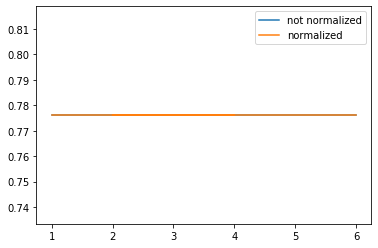

In [483]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def log_reg_pipeline(features, normalize_=True, print_=True):
    x = X[features].values
    x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.10, random_state=42)
    if normalize_:
        x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)
        clf = LogisticRegression(random_state=0).fit(x_train_nor, y_train)
        score = clf.score(x_test_nor, y_test)
        if print_:
            print("score on the test set : {}".format(score))
        return clf, score
    else:
        clf = LogisticRegression(random_state=0).fit(x_train, y_train)
        score = clf.score(x_test, y_test)
        if print_:
            print("score on the test set : {}".format(score))
        return clf, score

features_test = [
            ['politeness'],
            ['n_words', 'politeness', 'delta_role_politeness', 'delta_time_politeness'],
            ['n_words', 'politeness'],
            ['n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'n_requests', 'n_words', 'politeness'],
           ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'politeness'],
]

ax1 = []
ax2 = []
ax3 = []

for feature in features_test:
    _, score = log_reg_pipeline(feature, False, False)
    _, score_nor = log_reg_pipeline(feature, True, False)
    ax1.append(len(feature))
    ax2.append(score)
    ax3.append(score_nor)
    
_ = plt.plot(ax1, ax2)
_ = plt.plot(ax1, ax3)
_ = plt.legend(['not normalized', 'normalized'])

### Decision Trees

In [487]:
from sklearn.ensemble import RandomForestClassifier

features = ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',  'n_requests', 'n_words', 'politeness', 'n_sentences', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']
X = input_features[features]
Y = (input_features['season_before_betrayal'] == 1.0).values.astype(np.int)

def train_and_predict_random_forest(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    clf = RandomForestClassifier(n_estimators=1000, class_weight=get_class_weights(Y))
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=False, model_name="Random Forest")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=True, model_name="Random Forest")

Training model Random Forest..


/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Average F1-Score: 0.089
Average MMC-Score: nan
F1-Score: 95% confidence interval 0.000 and 0.400
Matthews Corr Coef: 95% confidence interval -0.088 and 0.441

Training model Random Forest..


/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Average F1-Score: 0.052
Average MMC-Score: nan
F1-Score: 95% confidence interval 0.000 and 0.235
Matthews Corr Coef: 95% confidence interval -0.057 and 0.299


/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [488]:
all_models_f1_scores.append(f1_output)
all_models_mmc_scores.append(mmc_output)
all_models_names.append("Random Forest")

{'acc': 0.776,
 'f1': 0.118,
 'fn': 14,
 'fp': 1,
 'mmc': 0.116194,
 'precision': 0.5,
 'recall': 0.067,
 'tn': 51,
 'tp': 1}

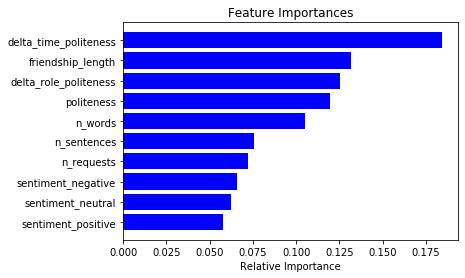

In [475]:
def train_rf_and_plot_importance(x_train, x_test, y_train, y_test ):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(x_train, y_train)

    importances = np.array(clf.feature_importances_)
    indices = np.argsort(importances)

    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), np.array(features)[indices])
    plt.xlabel('Relative Importance')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
train_rf_and_plot_importance(x_train, x_test, y_train, y_test)
train_and_predict_random_forest(x_train, x_test, y_train, y_test)

### Feed Forward Neural Network

In [490]:
BATCH_SIZE = 64
EPOCHS = 10
FEATURES_NUM = X.shape[-1]

def get_feed_forward_model():
    model = Sequential()
    model.add(Dense(units=512, activation='tanh', kernel_regularizer=L2(1e-5), bias_regularizer=L2(1e-5), input_shape=(FEATURES_NUM,)))
    model.add(Dense(units=256))
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(optimizer=opt, loss='binary_crossentropy')    
    return model

@contextlib.contextmanager
def local_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    tf.random.set_seed(seed)

    try:
        yield
    finally:
        np.random.set_state(state)
        tf.random.set_seed(np.random.randint(1000))
        
def train_and_predict_feed_forward_model(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3)

    class_weights = get_class_weights(Y)
    with local_seed(10):
        model = get_feed_forward_model()
        result = model.fit(
            x_train, 
            y_train, 
            batch_size = BATCH_SIZE, 
            epochs=10,
            callbacks=[es],
            validation_data=(x_test, y_test),
            class_weight=class_weights, verbose=0)

    y_pred = model.predict_step(x_test).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size=0.2)
print(train_and_predict_feed_forward_model(x_train, x_test, y_train, y_test))

f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_feed_forward_model, 20, stratify=True, model_name="Feedforward")

{'f1': 0.362, 'mmc': 0.08248, 'acc': 68.368, 'precision': 0.233, 'recall': 0.474, 'tp': 1953, 'fp': 6426, 'tn': 7140, 'fn': 2170}
Training model Feedforward..
Average F1-Score: 0.454
Average MMC-Score: 0.287
F1-Score: 95% confidence interval 0.352 and 0.631
Matthews Corr Coef: 95% confidence interval 0.145 and 0.550


In [491]:
all_models_f1_scores.append(f1_output)
all_models_mmc_scores.append(mmc_output)
all_models_names.append("Feed Forward NN")

# Plot model results

In [517]:
all_models_f1_scores.append([0.31, 0])
all_models_mmc_scores.append([0.15, 0])
all_models_names.append('Authors baseline')

f1_scores  = np.array(all_models_f1_scores)
mmc_scores = np.array(all_models_mmc_scores)

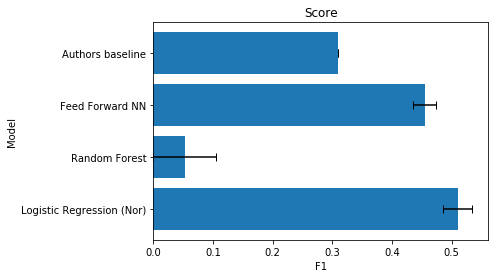

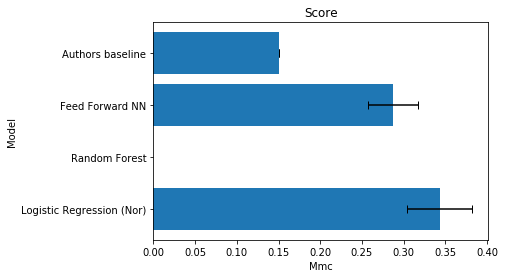

In [518]:
plt.barh(all_models_names, f1_scores[:, 0], xerr=f1_scores[:,1], capsize=4)
plt.title("Score")
plt.xlabel("f1".capitalize())
plt.ylabel("Model")
plt.show()

plt.barh(all_models_names, mmc_scores[:, 0], xerr=mmc_scores[:,1], capsize=4)
plt.title("Score")
plt.xlabel("mmc".capitalize())
plt.ylabel("Model")
plt.show()

# Explore word embeddings

In [20]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to /home/ina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
features_data = df.copy()

# Now train just for the betrayer role for changes, although we could add data for both?
features_data = features_data[features_data['role'] == 'betrayer']
features_data = features_data[features_data['betrayal'] == True]

features_data = features_data.drop(columns=['frequent_words', 'season_betrayal', 'role', 'betrayal'])

aggreagted_features_per_season = features_data.groupby(['idx', 'season'], as_index=False).aggregate({
    'sentiment_positive': 'mean',
    'sentiment_neutral': 'mean',
    'sentiment_negative': 'mean',
    'n_requests': 'mean',
    'n_words': 'sum',
    'politeness': 'mean',
    'n_sentences': 'sum',
    'season_before_betrayal': 'min', # equal for all anyway
    'all_words': 'sum'
})

X = aggreagted_features_per_season[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',
       'n_requests', 'n_words', 'politeness', 'n_sentences', 'all_words']]
Y = (aggreagted_features_per_season['season_before_betrayal'] == 1.0).values.astype('float32')

In [22]:
X.head()

,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,politeness,n_sentences,all_words
0,1.333333,1.333333,1.500000,3.666667,489,0.803328,25,"[prevent, this, before, one, but, ,, support, ..."
1,0.142857,0.857143,1.285714,1.285714,280,0.560083,16,"[on, turn, other, ?, are, of, one, new, like, ..."
2,2.000000,2.500000,2.000000,5.500000,333,0.982703,13,"[then, this, suggestions, one, but, ,, support..."
3,1.800000,0.800000,2.200000,3.200000,449,0.748802,24,"[hope, ., turkey, next, out, work, a, let's, g..."
4,1.000000,1.000000,1.000000,2.000000,78,0.899161,6,"[?, suggestions, some, hello, but, confused, ,..."


In [23]:
# Words combined look like this
print(X['all_words'][0][:50])

['prevent', 'this', 'before', 'one', 'but', ',', 'support', 'want', 'lose', 'enemy', 'ally', 'losing', 'an', 'a', 'my', 'we', 'crazy', 'saying', 'side', 'stp', 'our', "didn't", 'it', 'hand', 'up', 'something', 'still', 'if', 'will', 'decide', 'fall', 'am', 'you', 'retake', 'ground', 'the', 'might', 'with', 'by', 'yet', 'in', "don't", 'to', 'have', 'from', 'of', 'until', 'army', 'bounce', 'i']


In [24]:
# We notice multiple stop words need to be removed, as well as contractions
def clean_words(X):
    new_words = []
    for word in X:
        # We consider contractions not very valuable, as well as very short words/individual letters
        if len(word) <= 2 or '\'' in word:
            continue
        
        # Removing stop words
        if word in stopwords.words('english'):
            continue
        
        new_words.append(word)
    return new_words

X['all_words'] = X['all_words'].map(clean_words)

/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Max number of words per season 938
Mean number of words per season 81.11915535444948
Min number of words per season 0
Number of unique words are 2146


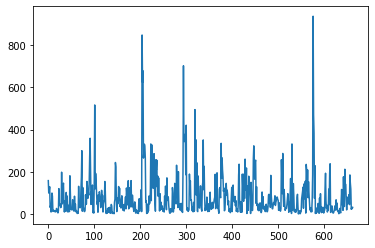

In [25]:
total_words_per_season = [len(X['all_words'][i]) for i in range(X.shape[0])]
print('Max number of words per season', np.max(total_words_per_season))
print('Mean number of words per season', np.mean(total_words_per_season))
print('Min number of words per season', np.min(total_words_per_season))

all_words = []
for idx in range(X.shape[0]):
    all_words = all_words + X['all_words'][idx]
print('Number of unique words are', len(set(all_words)))

plt.plot(total_words_per_season)
plt.show()

# Based on the following, we decide to pad/truncate to max 200 words and use an embedding matrix of 2140 words.

In [26]:
EMBEDDING_DIM = 25
MAX_WORDS = 2147
MAX_LEN = 200

def read_low_dim_glove_embeddings(filename):
    embeddings = {}
    
    f = open(filename)
    for line in f:
        values = line.split()
        word = values[0]
        embeddings[word] = np.asarray(values[1:], dtype='float32')
    f.close()
    
    print('Embeddings containing %s word vectors.' % len(embeddings))
    return embeddings

embeddings = read_low_dim_glove_embeddings('glove.twitter.27B.25d.txt')
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

word_to_idx = {}
idx = 0
for word in list(set(all_words)):
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        word_to_idx[word] = idx
    idx = idx + 1

def convert_word_to_id(words):
    values = [word_to_idx[w] for w in words if w in word_to_idx]
    
    return values

X['all_words'] = X['all_words'].map(convert_word_to_id)
X.head()

Embeddings containing 1193514 word vectors.


/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,politeness,n_sentences,all_words
0,1.333333,1.333333,1.500000,3.666667,489,0.803328,25,"[1342, 1486, 552, 1077, 1080, 1773, 826, 19, 1..."
1,0.142857,0.857143,1.285714,1.285714,280,0.560083,16,"[740, 1486, 1238, 76, 438, 587, 1661, 1631, 14..."
2,2.000000,2.500000,2.000000,5.500000,333,0.982703,13,"[1202, 1486, 552, 816, 1080, 700, 1782, 709, 1..."
3,1.800000,0.800000,2.200000,3.200000,449,0.748802,24,"[1420, 1290, 265, 1063, 624, 818, 460, 2114, 1..."
4,1.000000,1.000000,1.000000,2.000000,78,0.899161,6,"[1202, 545, 1620, 1835, 1431, 996, 1468, 1290,..."


In [27]:
def get_embedding_submodel():
    inputs = tf.keras.layers.Input(shape=(MAX_LEN))
    embedding = tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inputs)
    lstm = tf.keras.layers.LSTM(64, activation='relu', kernel_regularizer=L2(1e-5), bias_regularizer=L2(1e-5))(embedding)
    model = tf.keras.Model(inputs=inputs, outputs=lstm)
    return model

def get_numerical_submodel():
    inputs = tf.keras.layers.Input(shape=(7))
    dense = tf.keras.layers.Dense(64, kernel_regularizer=L2(1e-5), bias_regularizer=L2(1e-5))(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=dense)
    return model

def get_combined_model():
    model_embeddings = get_embedding_submodel()
    model_numerical = get_numerical_submodel()    
    combined = tf.keras.layers.concatenate([model_embeddings.output, model_numerical.output])
    dense = tf.keras.layers.Dense(32, activation='linear')(combined)
    dropout = tf.keras.layers.Dropout(0.4)(combined)
    final_output = tf.keras.layers.Dense(1, activation="sigmoid")(dense)

    model = tf.keras.models.Model(inputs=[model_embeddings.input, model_numerical.input], outputs=final_output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0005))
    return model

tf.keras.backend.clear_session()
model = get_combined_model()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 25)      53675       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           23040       embedding[0][0]                  
_______________________________________________________________________________________

In [28]:
def get_numerical_model_x_inputs(x_train, x_test):
    # Inputs for the numerical model
    numerical_model_features = ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',
           'n_requests', 'n_words', 'politeness', 'n_sentences']
    x_train = x_train[numerical_model_features]
    x_test = x_test[numerical_model_features]

    # Standardization of numerical features
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    return x_train, x_test

def get_embeddings_model_x_inputs(x_train, x_test):
    x_train = x_train['all_words']
    x_test = x_test['all_words']
    
    x_train = tf.keras.preprocessing.sequence.pad_sequences(list(x_train), maxlen=MAX_LEN, padding='post')
    x_test = tf.keras.preprocessing.sequence.pad_sequences(list(x_test), maxlen=MAX_LEN, padding='post')
    return x_train, x_test

def train_and_predict_fusion_model(x_train, x_test, y_train, y_test):
    x_train_1, x_test_1 = get_embeddings_model_x_inputs(x_train, x_test)
    x_train_2, x_test_2 = get_numerical_model_x_inputs(x_train, x_test)

    with local_seed(10):
        tf.keras.backend.clear_session()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3)

        model = get_combined_model()
        result = model.fit({'input_1': x_train_1, 'input_2': x_train_2},
            y_train, 
            batch_size = 64, 
            epochs=10,
            callbacks=[es],
            validation_data=({'input_1': x_test_1, 'input_2': x_test_2}, y_test),
            class_weight=class_weights, verbose=0)

    y_pred = model.predict_step({'input_1': x_test_1, 'input_2': x_test_2}).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)

f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_fusion_model, 20, stratify=True, model_name="Fusion model")
# x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size=0.2, shuffle=True)
# train_and_predict_fusion_model(x_train, x_test, y_train, y_test)
print('Average f1', f1_output[0])
print('Average mmc', mmc_output[0])

Training model Fusion model..
F1-Score: 95% confidence interval 0.086 and 0.388
Matthews Corr Coef: 95% confidence interval -0.258 and 0.117
Average f1 0.2699
Average mmc -0.050140599999999994


In [29]:
# Here is an attempt to learn from embeddings only

def get_embedding_model():
    inputs = tf.keras.layers.Input(shape=(MAX_LEN))
    embedding = tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inputs)
    lstm = tf.keras.layers.LSTM(64, activation='relu', kernel_regularizer=L2(1e-6))(embedding)
    dropout = tf.keras.layers.Dropout(0.4)(lstm)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0005))
    return model


def train_and_predict_embedding_model(x_train, x_test, y_train, y_test):
    x_train_1, x_test_1 = get_embeddings_model_x_inputs(x_train, x_test)

    with local_seed(10):
        tf.keras.backend.clear_session()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)

        model = get_embedding_model()
        result = model.fit(x_train_1,
            y_train, 
            batch_size = 128, 
            epochs=15,
#             callbacks=[es],
            validation_data=(x_test_1, y_test),
            class_weight=class_weights, verbose=1)

    y_pred = model.predict_step(x_test_1).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)


# x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size=0.2, shuffle=True)
# train_and_predict_embedding_model(x_train, x_test, y_train, y_test)
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_embedding_model, 20, stratify=False, model_name="Fusion model")

Training model Fusion model..
Epoch 1/15
5/5 [==============================] - 1s 153ms/step - loss: 0.6972 - val_loss: 0.7208
Epoch 2/15
5/5 [==============================] - 1s 106ms/step - loss: 0.6963 - val_loss: 0.6788
Epoch 3/15
5/5 [==============================] - 1s 122ms/step - loss: 0.6922 - val_loss: 0.6627
Epoch 4/15
5/5 [==============================] - 1s 102ms/step - loss: 0.6777 - val_loss: 0.6738
Epoch 5/15
5/5 [==============================] - 1s 127ms/step - loss: 0.6863 - val_loss: 0.6812
Epoch 6/15
5/5 [==============================] - 1s 100ms/step - loss: 0.6929 - val_loss: 0.6886
Epoch 7/15
5/5 [==============================] - 0s 98ms/step - loss: 0.6807 - val_loss: 0.6863
Epoch 8/15
5/5 [==============================] - 1s 102ms/step - loss: 0.6858 - val_loss: 0.6876
Epoch 9/15
5/5 [==============================] - 0s 93ms/step - loss: 0.6834 - val_loss: 0.6834
Epoch 10/15
5/5 [==============================] - 0s 96ms/step - loss: 0.6833 - val_loss:

/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Epoch 1/15
5/5 [==============================] - 1s 116ms/step - loss: 0.6697 - val_loss: 0.6766
Epoch 2/15
5/5 [==============================] - 0s 92ms/step - loss: 0.6695 - val_loss: 0.6239
Epoch 3/15
5/5 [==============================] - 0s 93ms/step - loss: 0.6725 - val_loss: 0.6324
Epoch 4/15
5/5 [==============================] - 0s 91ms/step - loss: 0.6538 - val_loss: 0.6473
Epoch 5/15
5/5 [==============================] - 0s 92ms/step - loss: 0.6485 - val_loss: 0.6554
Epoch 6/15
5/5 [==============================] - 0s 91ms/step - loss: 0.6732 - val_loss: 0.6529
Epoch 7/15
5/5 [==============================] - 0s 91ms/step - loss: 0.6621 - val_loss: 0.6550
Epoch 8/15
5/5 [==============================] - 0s 92ms/step - loss: 0.6559 - val_loss: 0.6522
Epoch 9/15
5/5 [==============================] - 0s 92ms/step - loss: 0.6550 - val_loss: 0.6472
Epoch 10/15
5/5 [==============================] - 0s 91ms/step - loss: 0.6489 - val_loss: 0.6502
Epoch 11/15
5/5 [===========

Epoch 2/15
5/5 [==============================] - 0s 84ms/step - loss: 0.6958 - val_loss: 0.6904
Epoch 3/15
5/5 [==============================] - 0s 91ms/step - loss: 0.7084 - val_loss: 0.6871
Epoch 4/15
5/5 [==============================] - 0s 97ms/step - loss: 0.6977 - val_loss: 0.6877
Epoch 5/15
5/5 [==============================] - 0s 95ms/step - loss: 0.7045 - val_loss: 0.6894
Epoch 6/15
5/5 [==============================] - 0s 99ms/step - loss: 0.6965 - val_loss: 0.6912
Epoch 7/15
5/5 [==============================] - 0s 98ms/step - loss: 0.6993 - val_loss: 0.6894
Epoch 8/15
5/5 [==============================] - 0s 100ms/step - loss: 0.6950 - val_loss: 0.6901
Epoch 9/15
5/5 [==============================] - 1s 100ms/step - loss: 0.6956 - val_loss: 0.6948
Epoch 10/15
5/5 [==============================] - 1s 100ms/step - loss: 0.6776 - val_loss: 0.6875
Epoch 11/15
5/5 [==============================] - 0s 98ms/step - loss: 0.6811 - val_loss: 0.6620
Epoch 12/15
5/5 [========

## Predicting in the future

In [274]:
from sklearn.ensemble import RandomForestClassifier

X, Y = data_2_roles[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles['season_before_betrayal'].values <= 3).astype(np.int)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = RandomForestClassifier(n_estimators=10000)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))
print(clf.feature_importances_)

result :  {'f1': 0.732, 'mmc': 0.313685, 'acc': 0.672, 'precision': 0.698, 'recall': 0.769, 'tp': 30, 'fp': 13, 'tn': 15, 'fn': 9}
[0.0837086  0.08476589 0.08434628 0.09016298 0.13661477 0.09820132
 0.15285928 0.1438306  0.12551028]


In [271]:
import xgboost

X, Y = data_2_roles[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles['season_before_betrayal'].values <= 3).astype(np.int)
ratio = float(np.sum(Y == 0)) / np.sum(Y == 1) #for XGBoost

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = xgboost.XGBClassifier(n_jobs=-1, scale_pos_weight=ratio, n_estimators=300, max_depth=20)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))
print(clf.feature_importances_)

result :  {'f1': 0.622, 'mmc': 0.159145, 'acc': 0.582, 'precision': 0.657, 'recall': 0.59, 'tp': 23, 'fp': 12, 'tn': 16, 'fn': 16}
[0.13518332 0.11615621 0.1170406  0.10638175 0.10464975 0.11983372
 0.10538792 0.08388288 0.11148385]


Text(0.5, 0, 'Relative Importance')

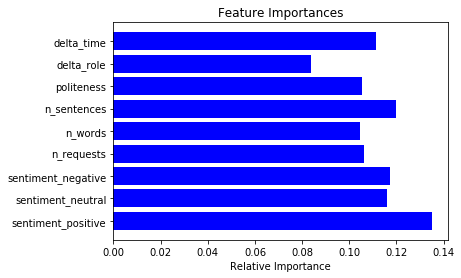

In [272]:
features=['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']
importances = clf.feature_importances_
# indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances, color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')

In [114]:
X, Y = data_2[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness']].values, (data_2['season_before_betrayal'].values <= 2).astype(np.int)

weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y)
class_weights = {0: weights[0], 1: weights[1]}

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.50, random_state=42)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = RandomForestClassifier(n_estimators=50, class_weight=class_weights)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))

result :  {'f1': 0.345, 'mmc': 0.129739, 'acc': 0.625, 'precision': 0.504, 'recall': 0.262, 'tp': 180, 'fp': 177, 'tn': 957, 'fn': 506}


In [147]:
import xgboost

X, Y = data_2_roles[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles['season_before_betrayal'].values <= 2).astype(np.int)
ratio = float(np.sum(Y == 0)) / np.sum(Y == 1) #for XGBoost

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = xgboost.XGBClassifier(n_jobs=-1, scale_pos_weight=ratio, n_estimators=300, max_depth=20)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))
print(clf.feature_importances_)

result :  {'f1': 0.404, 'mmc': 0.033189, 'acc': 0.534, 'precision': 0.467, 'recall': 0.356, 'tp': 21, 'fp': 24, 'tn': 50, 'fn': 38}
[0.12506528 0.11655457 0.11377538 0.13706627 0.10561607 0.09841212
 0.09687702 0.09557363 0.11105967]


# Foretell much from the past

In [260]:
data_2_roles_seaons_2 = data_2_roles[data_2_roles['season_before_betrayal'] >= 2]
data_2_roles_seaons_3 = data_2_roles[data_2_roles['season_before_betrayal'] >= 3]
data_2_roles_seaons_4 = data_2_roles[data_2_roles['season_before_betrayal'] >= 4]
data_2_roles_seaons_4 = data_2_roles[data_2_roles['season_before_betrayal'] >= 5]

In [202]:
data_2_roles_seaons_2.head()

role  sentiment_positive  sentiment_neutral  \
idx season                                                    
0   1906.5  betrayer            1.333333           1.333333   
    1907.0  betrayer            0.142857           0.857143   
    1907.5  betrayer            2.000000           2.500000   
    1908.0  betrayer            1.800000           0.800000   
    1908.5  betrayer            1.000000           1.000000   

            sentiment_negative  n_requests  n_words  n_sentences  politeness  \
idx season                                                                     
0   1906.5            1.500000    3.666667     81.5     4.166667    0.803328   
    1907.0            1.285714    1.285714     40.0     2.285714    0.560083   
    1907.5            2.000000    5.500000    166.5     6.500000    0.982703   
    1908.0            2.200000    3.200000     89.8     4.800000    0.748802   
    1908.5            1.000000    2.000000     39.0     3.000000    0.899161   

            season_before_betrayal  delta_role  delta_time  
idx season                                                  
0   1906.5                     6.0   -0.006665    0.000000  
    1907.0                     5.0   -0.225425   -0.243245  
    1907.5                     4.0    0.375372    0.422620  
    1908.0                     3.0    0.177667   -0.233901  
    1908.5                     2.0    0.335738    0.150360

In [233]:
X, Y = data_2_roles_seaons_2[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles_seaons_2['season_before_betrayal'].values == 2).astype(np.int)

weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y)
class_weights = {0: weights[0], 1: weights[1a

print(class_weights)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle=True)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = RandomForestClassifier(n_estimators=100,) # class_weight=class_weights)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))

{0: 0.6846153846153846, 1: 1.8541666666666667}
result :  {'f1': 0.189, 'mmc': 0.20226, 'acc': 0.733, 'precision': 0.714, 'recall': 0.109, 'tp': 5, 'fp': 2, 'tn': 113, 'fn': 41}


In [254]:
X, Y = data_2_roles_seaons_3[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles_seaons_3['season_before_betrayal'].values == 3).astype(np.int)

weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y)
class_weights = {0: weights[0], 1: weights[1]}

print(class_weights)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle=True)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = RandomForestClassifier(n_estimators=100,) # class_weight=class_weights)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))

{0: 0.6890459363957597, 1: 1.8224299065420562}
result :  {'f1': 0.267, 'mmc': 0.136685, 'acc': 0.718, 'precision': 0.429, 'recall': 0.194, 'tp': 6, 'fp': 8, 'tn': 78, 'fn': 25}


In [259]:
X, Y = data_2_roles_seaons_4[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles_seaons_4['season_before_betrayal'].values == 4).astype(np.int)

weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y)
class_weights = {0: weights[0], 1: weights[1]}

print(class_weights)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle=True)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = RandomForestClassifier(n_estimators=100,) # class_weight=class_weights)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))

{0: 0.7408376963350786, 1: 1.5380434782608696}
result :  {'f1': 0.25, 'mmc': 0.165342, 'acc': 0.647, 'precision': 0.625, 'recall': 0.156, 'tp': 5, 'fp': 3, 'tn': 50, 'fn': 27}


In [ ]:
X, Y = data_2_roles_seaons_5[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles_seaons_5['season_before_betrayal'].values == 5).astype(np.int)

weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y)
class_weights = {0: weights[0], 1: weights[1]}

print(class_weights)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle=True)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = RandomForestClassifier(n_estimators=100,) # class_weight=class_weights)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))

In [155]:
import xgboost

X, Y = data_2_roles_seaons_3[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role', 'delta_time']].values, (data_2_roles_seaons_3['season_before_betrayal'].values == 3).astype(np.int)
ratio = float(np.sum(Y == 0)) / np.sum(Y == 1) #for XGBoost

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

clf = xgboost.XGBClassifier(n_jobs=-1, scale_pos_weight=ratio, n_estimators=300, max_depth=20)
clf.fit(x_train_nor, y_train)

y_pred = clf.predict(x_test_nor)

print('result : ', evaluate_model(y_test, y_pred))
print(clf.feature_importances_)

result :  {'f1': 0.211, 'mmc': 0.025482, 'acc': 0.605, 'precision': 0.4, 'recall': 0.143, 'tp': 4, 'fp': 6, 'tn': 42, 'fn': 24}
[0.09449852 0.1036016  0.12157353 0.13993303 0.09435733 0.13205571
 0.10808396 0.10805522 0.09784104]


In [26]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation f1 score: {:.2f}".format(grid_search.best_score_))

NameError: name 'grid_search' is not defined